# Compare Flux_redshift in Data and in Model

- author : Sylvie Dagoret-Campagne
- date : March 16th 2021
- affiliation : IJCLab/IN2P3/CNRS

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [27]:
import sys
from mpi4py import MPI
import numpy as np
from scipy.interpolate import interp1d
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel
import scipy.stats
import matplotlib.pyplot as plt
import emcee
import corner

# Create a logger object.
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s %(name)s[%(process)d] %(levelname)s %(message)s')

comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()

In [28]:
from pkg_resources import resource_filename

# configuration

In [29]:
basedelight_datapath = resource_filename('delight', '../data')

In [30]:
topdir=os.path.join(basedelight_datapath,"CWW_SEDs")

In [31]:
configfilename="../analysis_input_rail/tmp/parametersTest.cfg"

In [32]:
files_sed_cww=["El_B2004a_fluxredshiftmod.txt","SB2_B2004a_fluxredshiftmod.txt","Sbc_B2004a_fluxredshiftmod.txt",
               "ssp_25Myr_z008_fluxredshiftmod.txt","Im_B2004a_fluxredshiftmod.txt","SB3_B2004a_fluxredshiftmod.txt",
               "Scd_B2004a_fluxredshiftmod.txt","ssp_5Myr_z008_fluxredshiftmod.txt"]

In [33]:
NSED=len(files_sed_cww)
NSED

8

In [34]:
def approx_flux_likelihood_multiobj(
        f_obs,  # no, nf
        f_obs_var,  # no, nf
        f_mod,  # no, nt, nf
        ell_hat,  # 1
        ell_var,  # 1
        returnChi2=False,
        normalized=True):
    """
    approx_flux_likelihood_multiobj
    
    
    
    
    """

    assert len(f_obs.shape) == 2
    assert len(f_obs_var.shape) == 2
    assert len(f_mod.shape) == 3
    no, nt, nf = f_mod.shape
    f_obs_r = f_obs[:, None, :]
    var = f_obs_var[:, None, :]
    invvar = np.where(f_obs_r/var < 1e-6, 0.0, var**-1.0)  # nz * nt * nf
    
    FOT = np.sum(f_mod * f_obs_r * invvar, axis=2)\
        + ell_hat / ell_var  # no * nt
    FTT = np.sum(f_mod**2 * invvar, axis=2)\
        + 1. / ell_var  # no * nt
    FOO = np.sum(f_obs_r**2 * invvar, axis=2)\
        + ell_hat**2 / ell_var  # no * nt
    
    sigma_det = np.prod(var, axis=2)
    chi2 = FOO - FOT**2.0 / FTT  # no * nt
    denom = np.sqrt(FTT)
    
    if normalized:
        denom *= np.sqrt(sigma_det * (2*np.pi)**nf * ell_var)
        
    like = np.exp(-0.5*chi2) / denom  # no * nt
    
    if returnChi2:
        return chi2
    else:
        return like


In [35]:
def lnprob(params, nt, allFluxes, allFluxesVar, zZmax, fmod_atZ, pmin, pmax):
    """
    lnprob(params, nt, allFluxes, allFluxesVar, zZmax, fmod_atZ, pmin, pmax)
    
    """
    if np.any(params > pmax) or np.any(params < pmin):
        return - np.inf

    alphas0 = dirichlet(params[0:nt], rsize=1).ravel()[None, :]  # 1, nt
    alphas1 = dirichlet(params[nt:2*nt], rsize=1).ravel()[None, :]  # 1, nt
    alphas_atZ = zZmax[:, None] * (alphas1 - alphas0) + alphas0  # no, nt
    
    # fmod_atZ: no, nt, nf
    fmod_atZ_t = (fmod_atZ * alphas_atZ[:, :, None]).sum(axis=1)[:, None, :]
    # no, 1, nf
    sigma_ell = 1e3
    like_grid = approx_flux_likelihood_multiobj(allFluxes, allFluxesVar, fmod_atZ_t, 1, sigma_ell**2.).ravel()  # no,
    eps = 1e-305
    ind = like_grid > eps
    theprob = np.log(like_grid[ind]).sum()
    return theprob


    

In [36]:
def plot_params(params):
    """
    plot_params(params)
    """
    fig, axs = plt.subplots(4, 4, figsize=(16, 8))
    axs = axs.ravel()
    alphas = params[0:nt]
    alpha0 = np.sum(alphas)
    dirsamples = dirichlet(alphas, 1000)
    for i in range(nt):
        mean = alphas[i]/alpha0
        std = np.sqrt(alphas[i] * (alpha0-alphas[i]) / alpha0**2 / (alpha0+1))
        axs[i].axvspan(mean-std, mean+std, color='gray', alpha=0.5)
        axs[i].axvline(mean, c='k', lw=2)
        axs[i].axvline(1/nt, c='k', lw=1, ls='dashed')
        axs[i].set_title('alpha0 = '+str(alphas[i]))
        axs[i].set_xlim([0, 1])
        axs[i].hist(dirsamples[:, i], 50, color="k", histtype="step")
    alphas = params[nt:2*nt]
    alpha0 = np.sum(alphas)
    dirsamples = dirichlet(alphas, 1000)
    for i in range(nt):
        mean = alphas[i]/alpha0
        std = np.sqrt(alphas[i] * (alpha0-alphas[i]) / alpha0**2 / (alpha0+1))
        axs[nt+i].axvspan(mean-std, mean+std, color='gray', alpha=0.5)
        axs[nt+i].axvline(mean, c='k', lw=2)
        axs[nt+i].axvline(1/nt, c='k', lw=1, ls='dashed')
        axs[nt+i].set_title('alpha1 = '+str(alphas[i]))
        axs[nt+i].set_xlim([0, 1])
        axs[nt+i].hist(dirsamples[:, i], 50, color="k", histtype="step")
    fig.tight_layout()
    return fig

In [37]:
logger.info("--- calibrate Template Mixture Priors ---")

paramFileName = configfilename
params = parseParamFile(paramFileName, verbose=True)
#params = parseParamFile(paramFileName, verbose=False)

2021-04-09 13:59:26,845 ipykernel_launcher.py __main__[239] INFO --- calibrate Template Mixture Priors ---
2021-04-09 13:59:26,906 ipykernel_launcher.py, delight.io[239] WARNING Input parameter file:../analysis_input_rail/tmp/parametersTest.cfg
2021-04-09 13:59:26,909 ipykernel_launcher.py, delight.io[239] WARNING Parameters read:


>  rootDir              ./
>  bands_directory      /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/FILTERS
>  bandNames            lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
>  numCoefs             15
>  bands_verbose        True
>  bands_debug          True
>  bands_makeplots      False
>  templates_directory  /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/CWW_SEDs
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  templates_verbose    False
>  templates_debug      False
>  training_numChunks   1
>  training_paramFile   ./tmp/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmp/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand lsst_i
>  training_bandOrder   lsst_u lsst_u_var lsst_g 

In [38]:
DL = approx_DL()
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)

In [39]:
numZ = redshiftGrid.size

In [40]:
# Locate which columns of the catalog correspond to which bands.
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,refBandColumn = readColumnPositions(params, prefix="training_")

In [41]:
bandIndices

array([0, 1, 2, 3, 4, 5])

In [42]:
bandNames

array(['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y'],
      dtype='<U6')

In [43]:
bandColumns

array([ 0,  2,  4,  6,  8, 10])

In [44]:
bandVarColumns

array([ 1,  3,  5,  7,  9, 11])

In [45]:
redshiftColumn

12

In [46]:
refBandColumn

6

In [47]:
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']

In [48]:
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
numBands = bandIndices.size
nt = len(sed_names)

In [49]:
f_mod = np.zeros((numZ, nt, len(params['bandNames'])))

In [50]:
# model of flux-redshift for each template
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

In [51]:
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))

<ipython-input-51-67f73946292d>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


In [52]:
msg = 'Number of Training Objects ' + str(numObjectsTraining)
logger.info(msg)

2021-04-09 13:59:27,398 ipykernel_launcher.py __main__[239] INFO Number of Training Objects 3755


In [53]:
numMetrics = 7 + len(params['confidenceLevels'])

In [54]:
allFluxes = np.zeros((numObjectsTraining, numBands))
allFluxesVar = np.zeros((numObjectsTraining, numBands))

redshifts = np.zeros((numObjectsTraining, 1))
fmod_atZ = np.zeros((numObjectsTraining, nt, numBands))

In [55]:
# Now loop over training set to compute likelihood function
loc = - 1
trainingDataIter = getDataFromFile(params, 0, numObjectsTraining,prefix="training_", getXY=False)

In [56]:
# loop on traning
for z, ell, bands, fluxes, fluxesVar, bCV, fCV, fvCV in trainingDataIter:
   
    loc += 1
   
    allFluxes[loc, :] = fluxes
    allFluxesVar[loc, :] = fluxesVar
    redshifts[loc, 0] = z
    
    # loop on SED
    for t, sed_name in enumerate(sed_names):
        for ib, b in enumerate(bands):
            fmod_atZ[loc, t, ib] = ell * np.interp(z, redshiftGrid,f_mod[:, t, b])

In [57]:
allFluxes.shape

(3755, 6)

In [58]:
fmod_atZ.shape 

(3755, 8, 6)

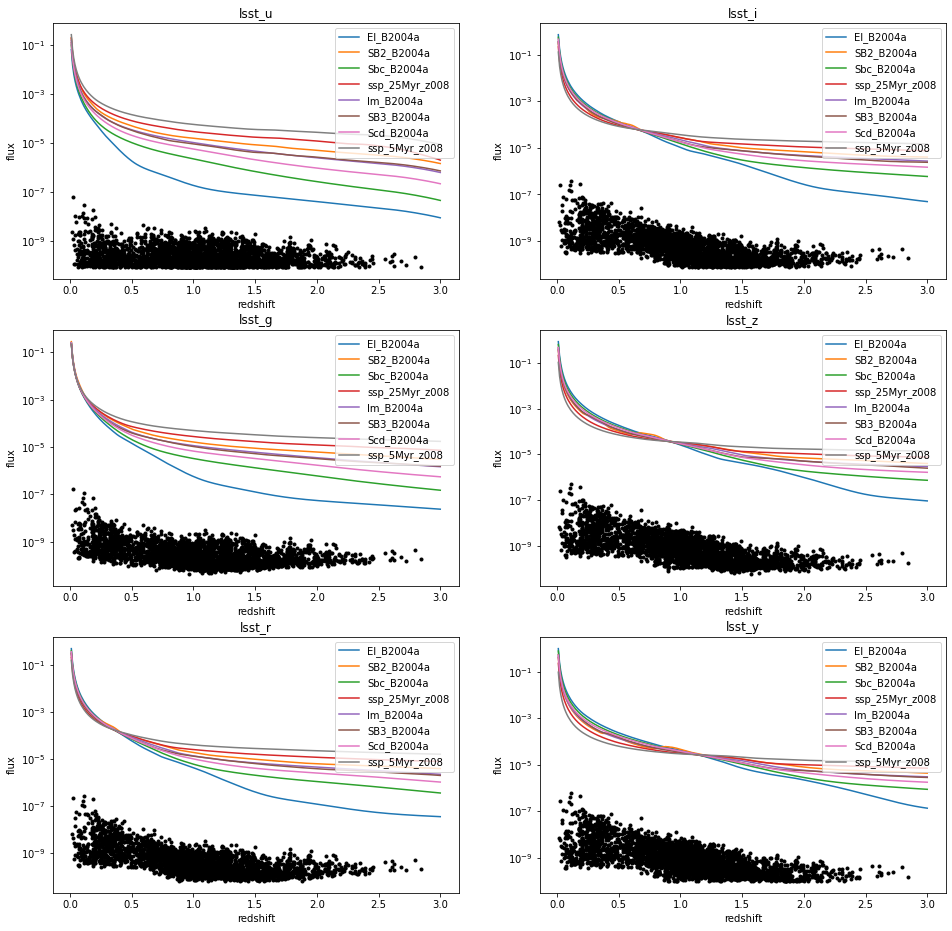

In [59]:
ncol=2
nrow=3
fig, axes = plt.subplots(nrow, ncol,figsize=(16,16)) 

for ised in np.arange(NSED):
    filename=files_sed_cww[ised]
    sedname=filename.split("_fluxredshiftmod")[0]
    fullfilename=os.path.join(topdir,filename)
    flux=np.loadtxt(fullfilename)
    for ifilt in np.arange(6):
        ix=ifilt//3
        iy=ifilt-ix*3
        
        axes[iy,ix].plot(redshiftGrid,flux[:,ifilt],label=sedname)
        axes[iy,ix].legend(loc="upper right")
        if ised==0:
            axes[iy,ix].set_yscale("log")
            axes[iy,ix].set_title(bandNames[ifilt])
            axes[iy,ix].set_xlabel("redshift")
            axes[iy,ix].set_ylabel("flux")
            axes[iy,ix].scatter(redshifts[:, 0],allFluxes[:, ifilt],marker=".",color="k" )
            
    
